# Thêm thư viện cần thiết


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')


# Nạp dữ liệu


In [9]:
train_BTC = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/7_3/btc/bitcoin_train_7_3.csv", parse_dates=True, index_col=0)
train_BTC.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,9.4545,10.3018,9.4297,10.1893,796676,USD
2020-06-02,10.1907,10.2073,9.3473,9.5276,1058556,USD
2020-06-03,9.5270,9.6672,9.4217,9.6672,558116,USD
2020-06-04,9.6672,9.8644,9.4909,9.7944,593664,USD
2020-06-05,9.7940,9.8461,9.6287,9.6312,527054,USD


In [10]:
train = train_BTC[["Open"]]
train.head(5)

,Open
Date,
2020-06-01,9.4545
2020-06-02,10.1907
2020-06-03,9.5270
2020-06-04,9.6672
2020-06-05,9.7940


In [11]:
test_BTC = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/7_3/btc/bitcoin_test_7_3.csv", parse_dates=True, index_col=0)
test_BTC.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2021-10-26,63.0675,63.2751,59.9073,60.3108,57131,USD
2021-10-27,60.3125,61.4529,58.1126,58.4381,88112,USD
2021-10-28,58.4372,62.2513,58.1281,60.5825,88470,USD
2021-10-29,60.5799,62.9522,60.3222,62.2428,63388,USD
2021-10-30,62.2450,62.3385,60.7860,61.8401,40507,USD


In [12]:
test = test_BTC[["Open"]]
test.head(5)

,Open
Date,
2021-10-26,63.0675
2021-10-27,60.3125
2021-10-28,58.4372
2021-10-29,60.5799
2021-10-30,62.2450


In [13]:
df = pd.concat([train.reset_index(level=0), test.reset_index(level=0)],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.index=df.Date
df.drop("Date", axis=1, inplace=True)
df.head(5)    

,Open
Date,
2020-06-01,9.4545
2020-06-02,10.1907
2020-06-03,9.5270
2020-06-04,9.6672
2020-06-05,9.7940


# Vẽ đồ thị

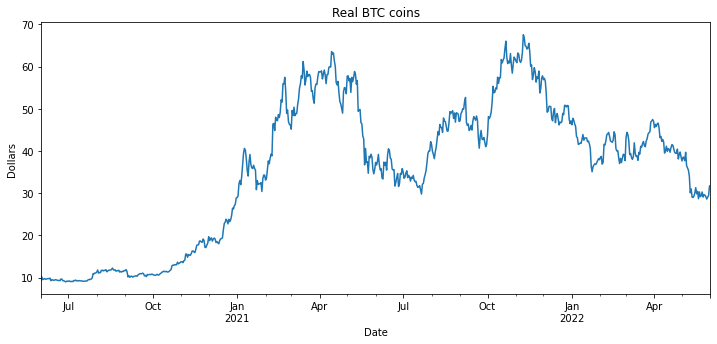

In [14]:
# Thư viện vẽ đồ thị
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real BTC coins'
ylabel='Dollars'
xlabel='Date' 

ax = df['Open'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Kiểm tra tính dừng của chuỗi

In [15]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")


In [16]:
adf_test(df['Open'], 'Bitcoin Price')


Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.711262
p-value                     0.425319
Number of lags used         0.000000
Number of observations    730.000000
critical value (1%)        -3.439340
critical value (5%)        -2.865507
critical value (10%)       -2.568883
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


##### Nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng


# Lấy sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng


In [17]:
df['diff1'] = df['Open'].diff()
df.head()


,Open,diff1
Date,,
2020-06-01,9.4545,NaN
2020-06-02,10.1907,0.7362
2020-06-03,9.5270,-0.6637
2020-06-04,9.6672,0.1402
2020-06-05,9.7940,0.1268


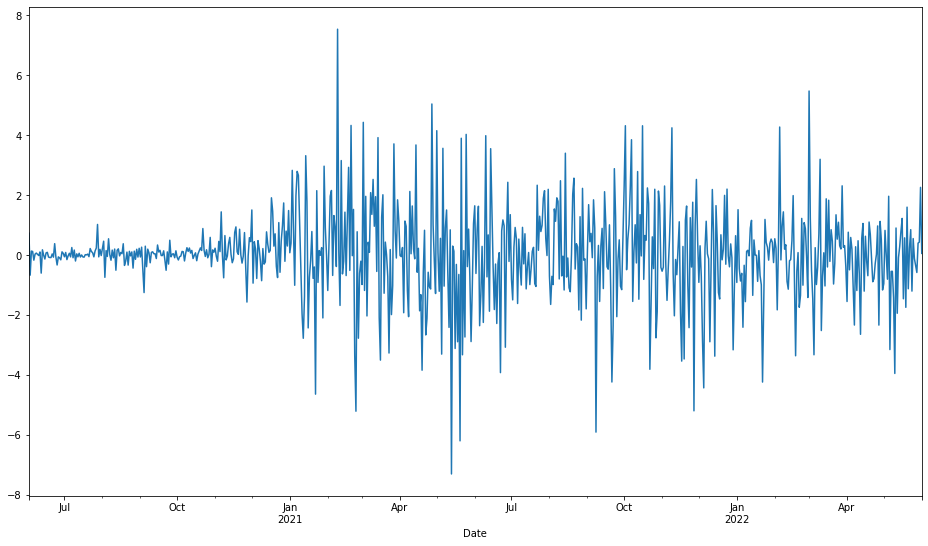

In [18]:
df['diff1'].dropna().plot(figsize=(16, 9))


# Kiểm định tính dừng của chuỗi tại sai phân bậc 1


In [19]:
adf_test(df['diff1'], 'Bitcoin Price at First Difference')


Augmented Dickey-Fuller Test: Bitcoin Price at First Difference
ADF test statistic        -28.115359
p-value                     0.000000
Number of lags used         0.000000
Number of observations    729.000000
critical value (1%)        -3.439352
critical value (5%)        -2.865513
critical value (10%)       -2.568886
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


##### Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1


# Thực hiện xây dựng mô hình ARIMA

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [20]:
df_scaled = df.copy().drop(columns=['diff1'])

scaler = StandardScaler()

df_scaled['Open'] = scaler.fit_transform(df_scaled['Open'].values.reshape(-1, 1))
df_scaled.head()

,Open
Date,
2020-06-01,-1.566754
2020-06-02,-1.522736
2020-06-03,-1.562419
2020-06-04,-1.554036
2020-06-05,-1.546455


## Chia dữ liệu thành tập train và tập test

In [21]:
interrupt = len(train)
interrupt

512

In [22]:
index_test = df_scaled.index[interrupt:]
print(train.shape)
print(test.shape)
print(index_test.shape)

(512, 1)
(219, 1)
(219,)


In [23]:
train.tail()

,Open
Date,
2021-10-21,66.0046
2021-10-22,62.2008
2021-10-23,60.6932
2021-10-24,61.3082
2021-10-25,60.8643


In [24]:
test.head()

,Open
Date,
2021-10-26,63.0675
2021-10-27,60.3125
2021-10-28,58.4372
2021-10-29,60.5799
2021-10-30,62.2450


## Tìm các hệ số p, q và d phù hợp cho mô hình ARIMA

In [25]:
warnings.filterwarnings('ignore')


def arima_model(ts_data):
    fit_model = auto_arima(ts_data, test='adf', seasonal=False, trace=True)
    print(fit_model.summary())
    return fit_model


#### Dựa vào chỉ số AIC
- Chỉ số AIC càng thấp thì mô hình càng phù hợp

In [26]:
fitted = arima_model(train)
fitted.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1872.518, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1872.712, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1872.837, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1872.794, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1874.325, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.077 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  512
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -934.259
Date:                Sun, 26 Jun 2022   AIC                           1872.518
Time:                        02:16:07   BIC                           1880.991
Sample:                             0   HQIC                          1875.840
               

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  512
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -934.259
Date:                Sun, 26 Jun 2022   AIC                           1872.518
Time:                        02:16:07   BIC                           1880.991
Sample:                             0   HQIC                          1875.840
                                - 512                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1006      0.067      1.509      0.131      -0.030       0.231
sigma2         2.2676      0.082     27.761      0.000       2.107       2.428
===================================================================================
Ljung-Box (L1) (Q):                   1.82   Jarque-Bera (JB):               349.53
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):              36.39   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test


In [27]:
pred = fitted.predict(len(test))
pred


array([60.96490626, 61.06551252, 61.16611879, 61.26672505, 61.36733131,
       61.46793757, 61.56854384, 61.6691501 , 61.76975636, 61.87036262,
       61.97096888, 62.07157515, 62.17218141, 62.27278767, 62.37339393,
       62.4740002 , 62.57460646, 62.67521272, 62.77581898, 62.87642524,
       62.97703151, 63.07763777, 63.17824403, 63.27885029, 63.37945656,
       63.48006282, 63.58066908, 63.68127534, 63.7818816 , 63.88248787,
       63.98309413, 64.08370039, 64.18430665, 64.28491292, 64.38551918,
       64.48612544, 64.5867317 , 64.68733796, 64.78794423, 64.88855049,
       64.98915675, 65.08976301, 65.19036928, 65.29097554, 65.3915818 ,
       65.49218806, 65.59279432, 65.69340059, 65.79400685, 65.89461311,
       65.99521937, 66.09582564, 66.1964319 , 66.29703816, 66.39764442,
       66.49825068, 66.59885695, 66.69946321, 66.80006947, 66.90067573,
       67.001282  , 67.10188826, 67.20249452, 67.30310078, 67.40370705,
       67.50431331, 67.60491957, 67.70552583, 67.80613209, 67.90

# Vẽ đồ thị cho tập test và kết quả dự đoán

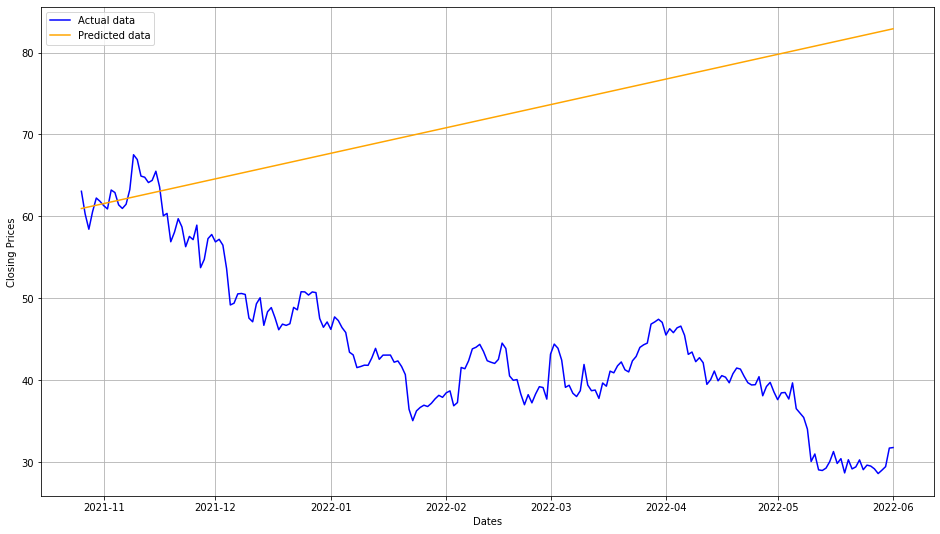

In [28]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test, 'blue', label='Actual data')
plt.plot(pred_series, 'orange', label='Predicted data')
plt.legend()


# Đưa dữ liệu về miền giá trị ban đầu


In [29]:
actual = column_or_1d(test)
pred = column_or_1d(pred)

inv_actual = scaler.inverse_transform(actual.reshape(-1, 1))
inv_pred = scaler.inverse_transform(pred.reshape(-1, 1))


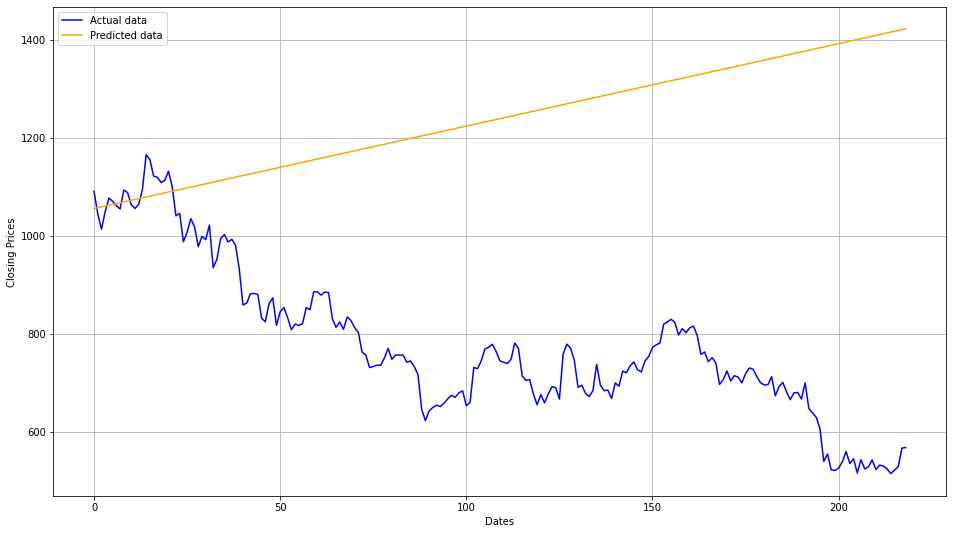

In [30]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_actual, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình qua các chỉ số MAE, MAPE, MSE, RMSE

In [31]:
# mae = mean_absolute_error(inv_actual, inv_pred)
mape = mean_absolute_percentage_error(inv_actual, inv_pred)
mse = mean_squared_error(inv_actual, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_actual, inv_pred)

# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


MAPE: 68.18%
RMSE: 525.30
R2: -10.51
